# Finding Balrog Term
aproximation

In [ ]:
#np.linspace(-0.5, n_wide**2 + 0.5, 1)

In [1]:
n_wide = 26
n_deep = 48
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30

def goldish_cut(df):
    '''
    will need to be updated once we have all columns used in the actual gold cut
    '''
    # count how many galaxies pass the metacal cuts
    # histogram to compare distributions 2d contour triangle plot
    #print(df)
    flux_r, flux_i, flux_z = df['FLUX_r'], df['FLUX_i'], df['FLUX_z']
    flux_err_r, flux_err_i, flux_err_z = df['FLUX_r_ERR'], df['FLUX_i_ERR'],  df['FLUX_z_ERR']

    # flux_err_r, flux_err_i, flux_err_z = np.array(f['mcal_flux_err_noshear']).T
    mag_r = flux2mag(flux_r)
    mag_i = flux2mag(flux_i)
    mag_z = flux2mag(flux_z)

    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    SNR = np.sqrt((flux_i/flux_err_r)**2 + (flux_r/flux_err_r)**2 + (flux_z/flux_err_z)**2) #calculate another way, divide flux/fluxerr

    #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask = (SNR > 10) & (SNR < 1000)

    Mask = mcal_pz_mask & SNR_Mask
    return Mask

In [3]:
wide = pd.read_csv('/project/chihway/raulteixeira/data/BalorgOfTheDECADE_v01_29072023_cells_wide_26x26.csv.gz')
deep = pd.read_csv('/project/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')
wide_deep = pd.read_csv('/project/chihway/raulteixeira/data/BalorgOfTheDECADE_v01_29072023_cells_wide_deep_26x26.csv.gz')

wide['ID']=wide.coadd_object_id
wide_deep['wide_cells']=wide_deep.cells_x
wide_deep['deep_cells']=wide_deep.cells_y

In [4]:
wide['passes'] = goldish_cut(wide)
wide_deep['passes'] = goldish_cut(wide_deep)

/home/raulteixeira/.conda/envs/raul/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/raulteixeira/.conda/envs/raul/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
unique_ids, counts_true = np.unique(wide.ID.values, return_counts=True)
unique_ids_detected, counts_detected = np.unique(wide.ID.values[wide.passes.values], return_counts=True)

df0 = pd.DataFrame()

df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()

df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left')

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] #p(\hat{c})

wide = wide.merge(df_[['ID', 'p_pass']], on='ID')

/tmp/ipykernel_28826/1155709000.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0


In [6]:
det_mask = wide.detected

In [7]:
np.isin(np.arange(0, n_wide**2), wide.cells[det_mask]).all()

True

In [8]:
wide['detected_float'] = wide.detected.astype(float)

In [9]:
wide.detected.sum()

23288

In [10]:
# now. classify those galaxies in the wide SOM (OK)
# when dhayaa sends new catalog. match with deep field catalog with astropy RA, DEC (Dhayaa is working on it!)
# 2. calculate the rate each object passes through gold cuts
    # 2.1 make n(z)'s (including tomo bins) (use cosmos z column for p(z|c),
    # weighted by the probabilities of points 1. and 2.)
    # 2.2 weight the p(c) by these weights
    
            #!!! P_PASS is weights!!! DONT FORGET TO MULTIPLY
            #p(c) and p(c_hat) are just p_pass*det_rate

# 3 calculate joint probability of p(c,c_hat)
    #how to do this:
        # * literally count how many (c, c_hat) pairs there are and do that
        # once you have p(c), p(c_hat), and p(c,c_hat) you have the balrog term!!! (seems like the hardest bit)

# IDs that were used for the injection of the catalog



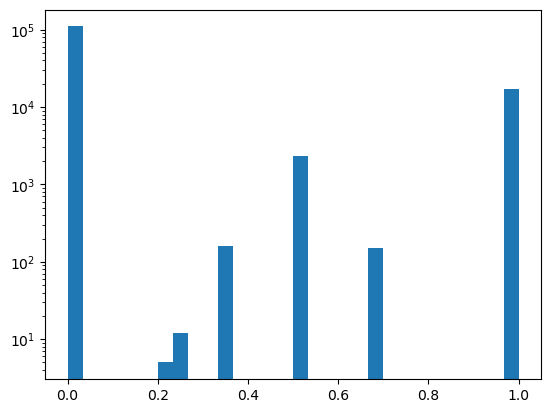

In [11]:
plt.yscale('log')
plt.hist(wide['p_pass'], bins=30);

In [12]:
unique_ids, counts_true = np.unique(wide_deep.ID.values, return_counts=True)
unique_ids_detected, counts_detected = np.unique(wide_deep.ID.values[wide_deep.passes.values], return_counts=True)

df0 = pd.DataFrame()

df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()

df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left')

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] #p(\hat{c})

wide_deep = wide_deep.merge(df_[['ID', 'p_pass']], on='ID')

/tmp/ipykernel_28826/3892994784.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0


In [13]:
cells_wide = wide[det_mask].cells.values
cells_deep = deep.cells.values
#cells_wide_deep = wide_deep.cells.values
emptycells_wide = np.arange(0, n_wide**2)[~np.isin(np.arange(0, n_wide**2), cells_wide)]
emptycells_deep = np.arange(0, n_deep**2)[~np.isin(np.arange(0, n_deep**2), cells_deep)]
#emptycells_wide_deep = np.arange(0, n**2)[~np.isin(np.arange(0, n**2), cells_wide_deep)]

In [14]:
lines = []
for i, cell in enumerate(emptycells_wide):
    df_i = pd.DataFrame({f"{col}": (np.nan if col!='cells' else cell) for col in wide.columns}, index=[wide.index.stop+i])
    #print(df_i)
    lines.append(df_i)

if len(lines):
    emptylines = pd.concat(lines, ignore_index=False)

    wide_clean = pd.concat([wide[det_mask], emptylines], ignore_index=False)
else:
    wide_clean = wide[det_mask]
    

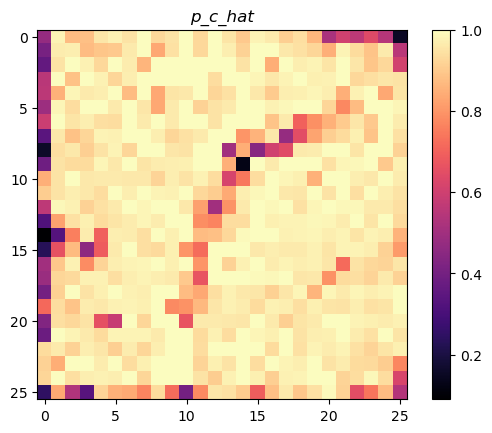

In [15]:
cmap='magma'
fun = 'mean'
feat = 'p_pass'
vmin,vmax=None,None#-1,3
norm=None
title = 'p_c_hat'
square_p_c_hat = wide[det_mask][[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])

im_i = square_p_c_hat[(feat, fun)].values.reshape(n_wide,n_wide)
image = plt.imshow(im_i, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

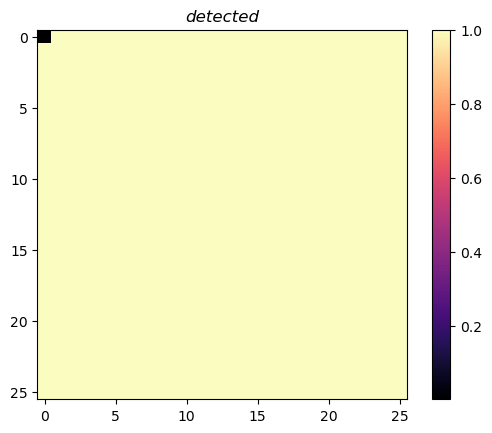

In [16]:
feat = 'detected_float'

wide[feat] = wide.detected.astype(float)
cmap='magma'
fun = 'mean'
vmin,vmax=None,None#-1,3
norm=None
title = 'detected'
square_det = wide[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])

im_i = square_det[(feat, fun)].values.reshape(n_wide,n_wide)
image = plt.imshow(im_i, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

# avg(det_rate/#times it was injected) in each cell

In [17]:
wide[wide['cells']==0].detected.any()

True

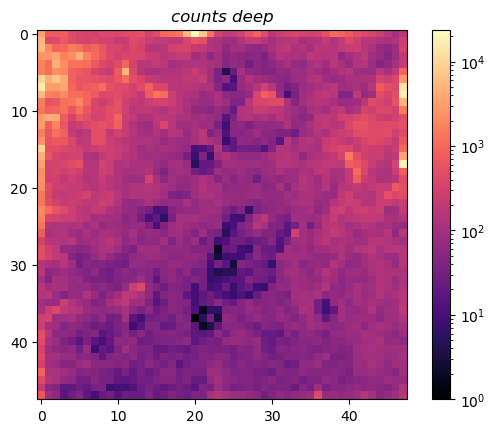

In [18]:
cmap='magma'
fun = 'len'
feat = 'i'
vmin,vmax=None,None#-1,3
norm=None
title = 'counts deep'
square_len_deep = deep[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])

im_i = square_len_deep[(feat, fun)].values.reshape(n_deep,n_deep)
image = plt.imshow(im_i, cmap=cmap, vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm())
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

In [19]:
#now count pairs of (cell_wide, cell_deep)

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wide_deep[wide_deep.detected].loc[129541])

Unnamed: 0                        129536
Unnamed: 0_x                      129536
Ai                                   0.0
Ar                                   0.0
Az                                   0.0
FLUX_i                         1233.6742
FLUX_i_ERR                      61.79203
FLUX_r                         662.75024
FLUX_r_ERR                      25.23898
FLUX_z                         1831.6389
FLUX_z_ERR                      75.78295
Truth_ind                         663870
coadd_object_id                700225672
d_arcsec                        0.047497
dec                             8.945626
detected                            True
ra                             232.69063
true_FLUX_i                    1558.3599
true_FLUX_r                     875.1336
true_FLUX_z                    2005.2842
true_dec                        8.945614
true_ra                        232.69063
cells_x                              485
ID                             700225672
Unnamed: 0_y    

In [21]:
wide_deep_mask = wide_deep.detected&np.isfinite(wide_deep.deep_cells)
WD_grid = np.array([[x,y] for x, y in zip(wide_deep[wide_deep_mask]['wide_cells'].values,\
                                          wide_deep[wide_deep_mask]['deep_cells'].values)])


In [22]:
WD_grid

array([[ 418., 1293.],
       [ 346.,  840.],
       [ 616., 2009.],
       ...,
       [  22., 1193.],
       [ 408.,  456.],
       [ 418.,  581.]])

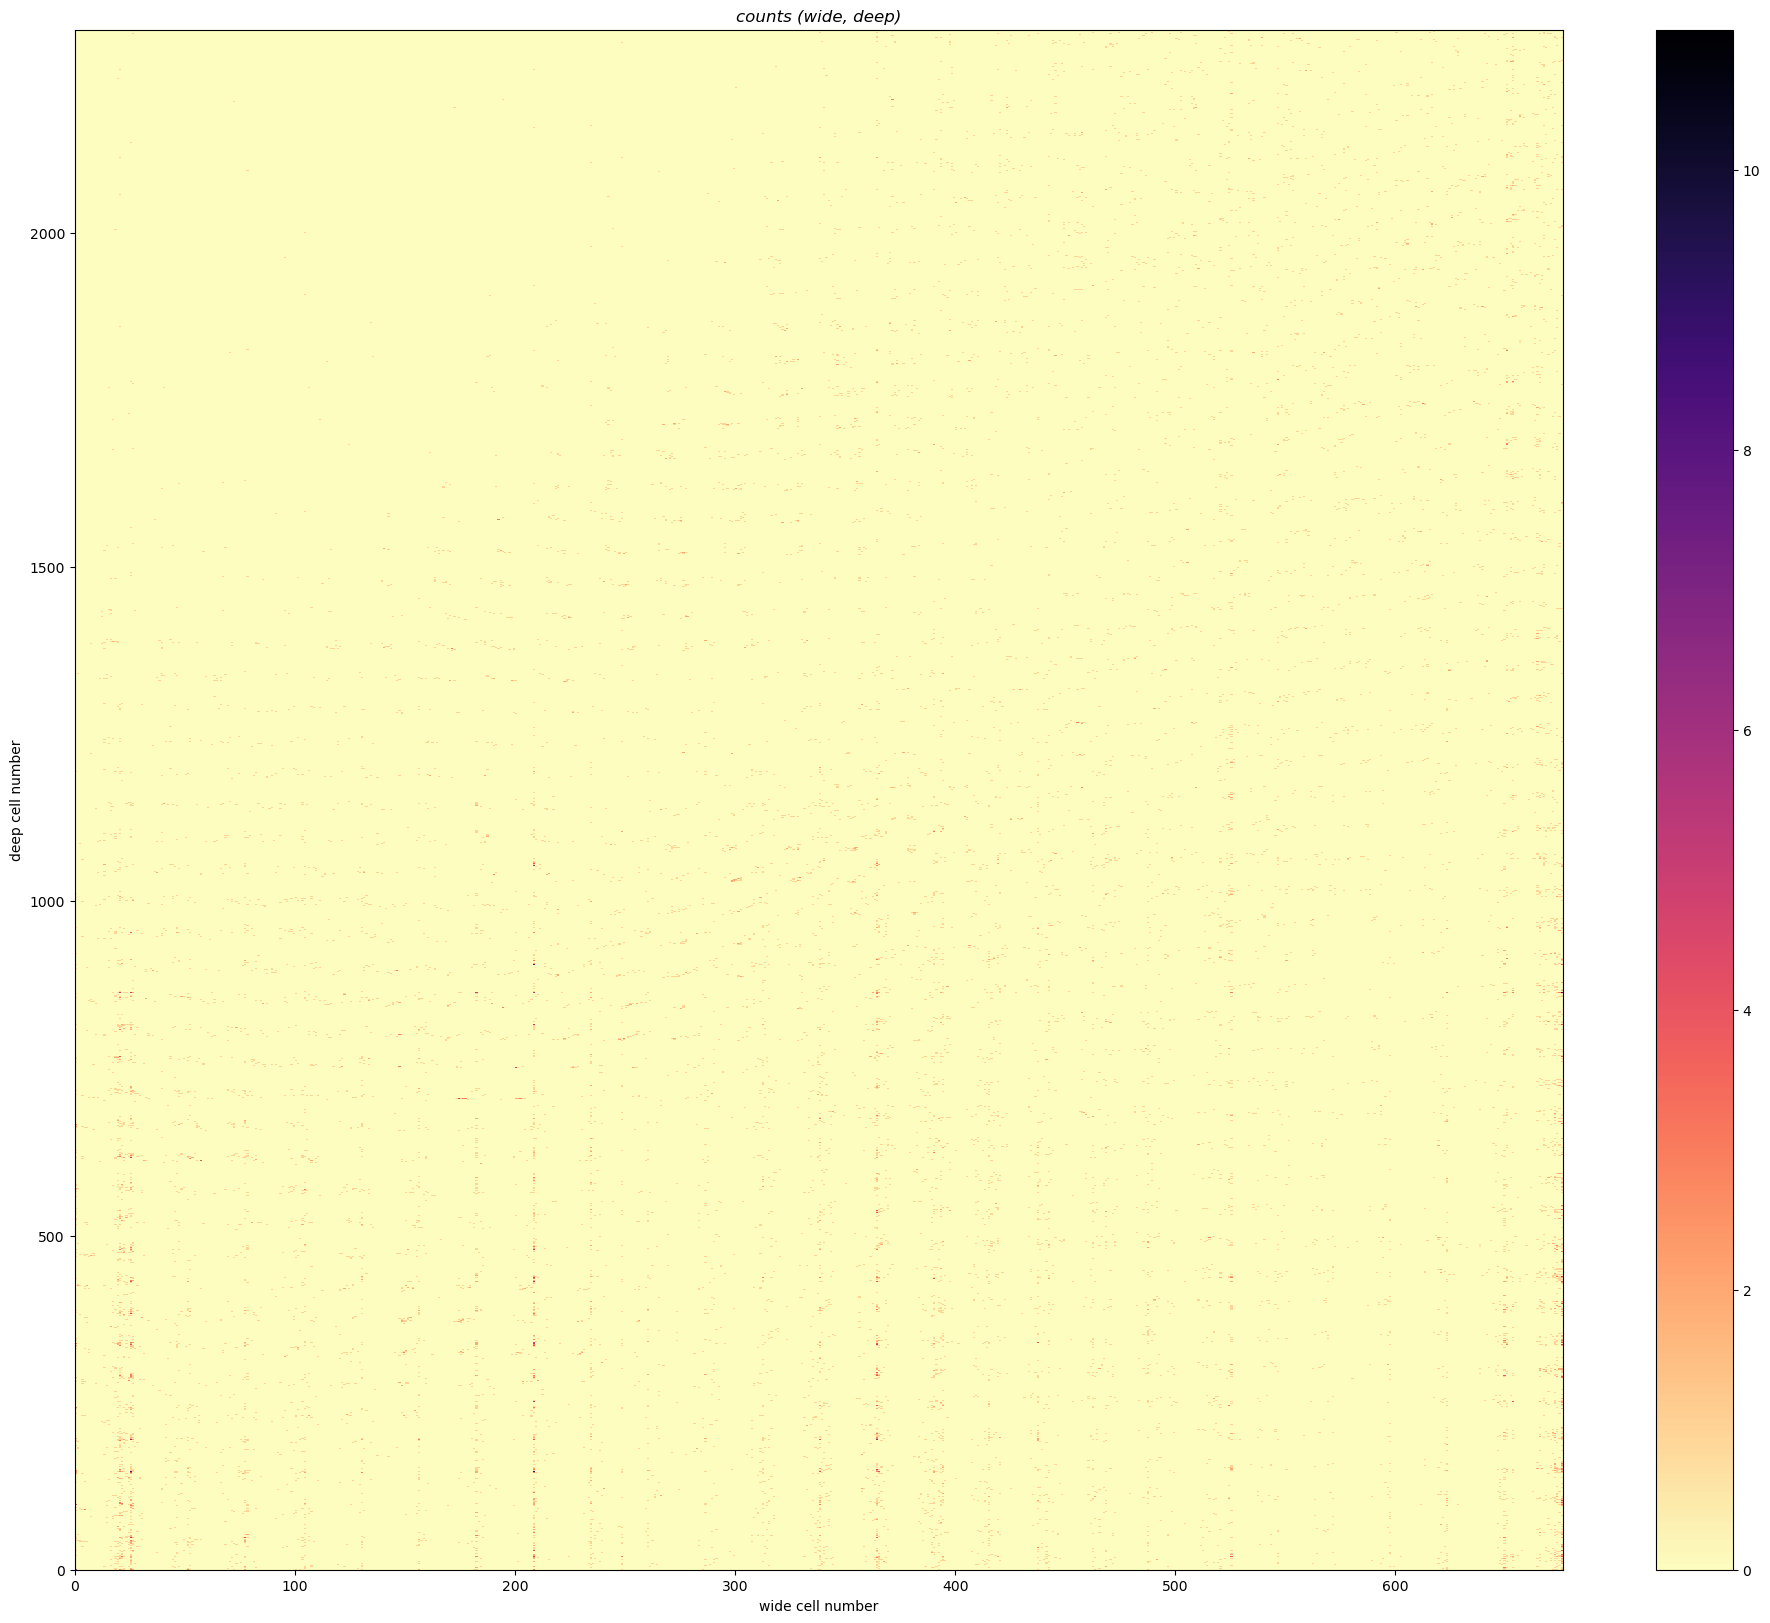

In [79]:
cmap='magma_r'
title = 'counts (wide, deep)'
plt.figure(figsize=(24,20))
plt.title(f'{title}',style='italic')
plt.xlabel('wide cell number')
plt.ylabel('deep cell number')
hist = plt.hist2d(WD_grid[:,0], WD_grid[:,1] ,bins=[np.arange(0,n_wide**2+1), np.arange(0,n_deep**2+1)],\
           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, label='counts')
plt.colorbar()
plt.show()

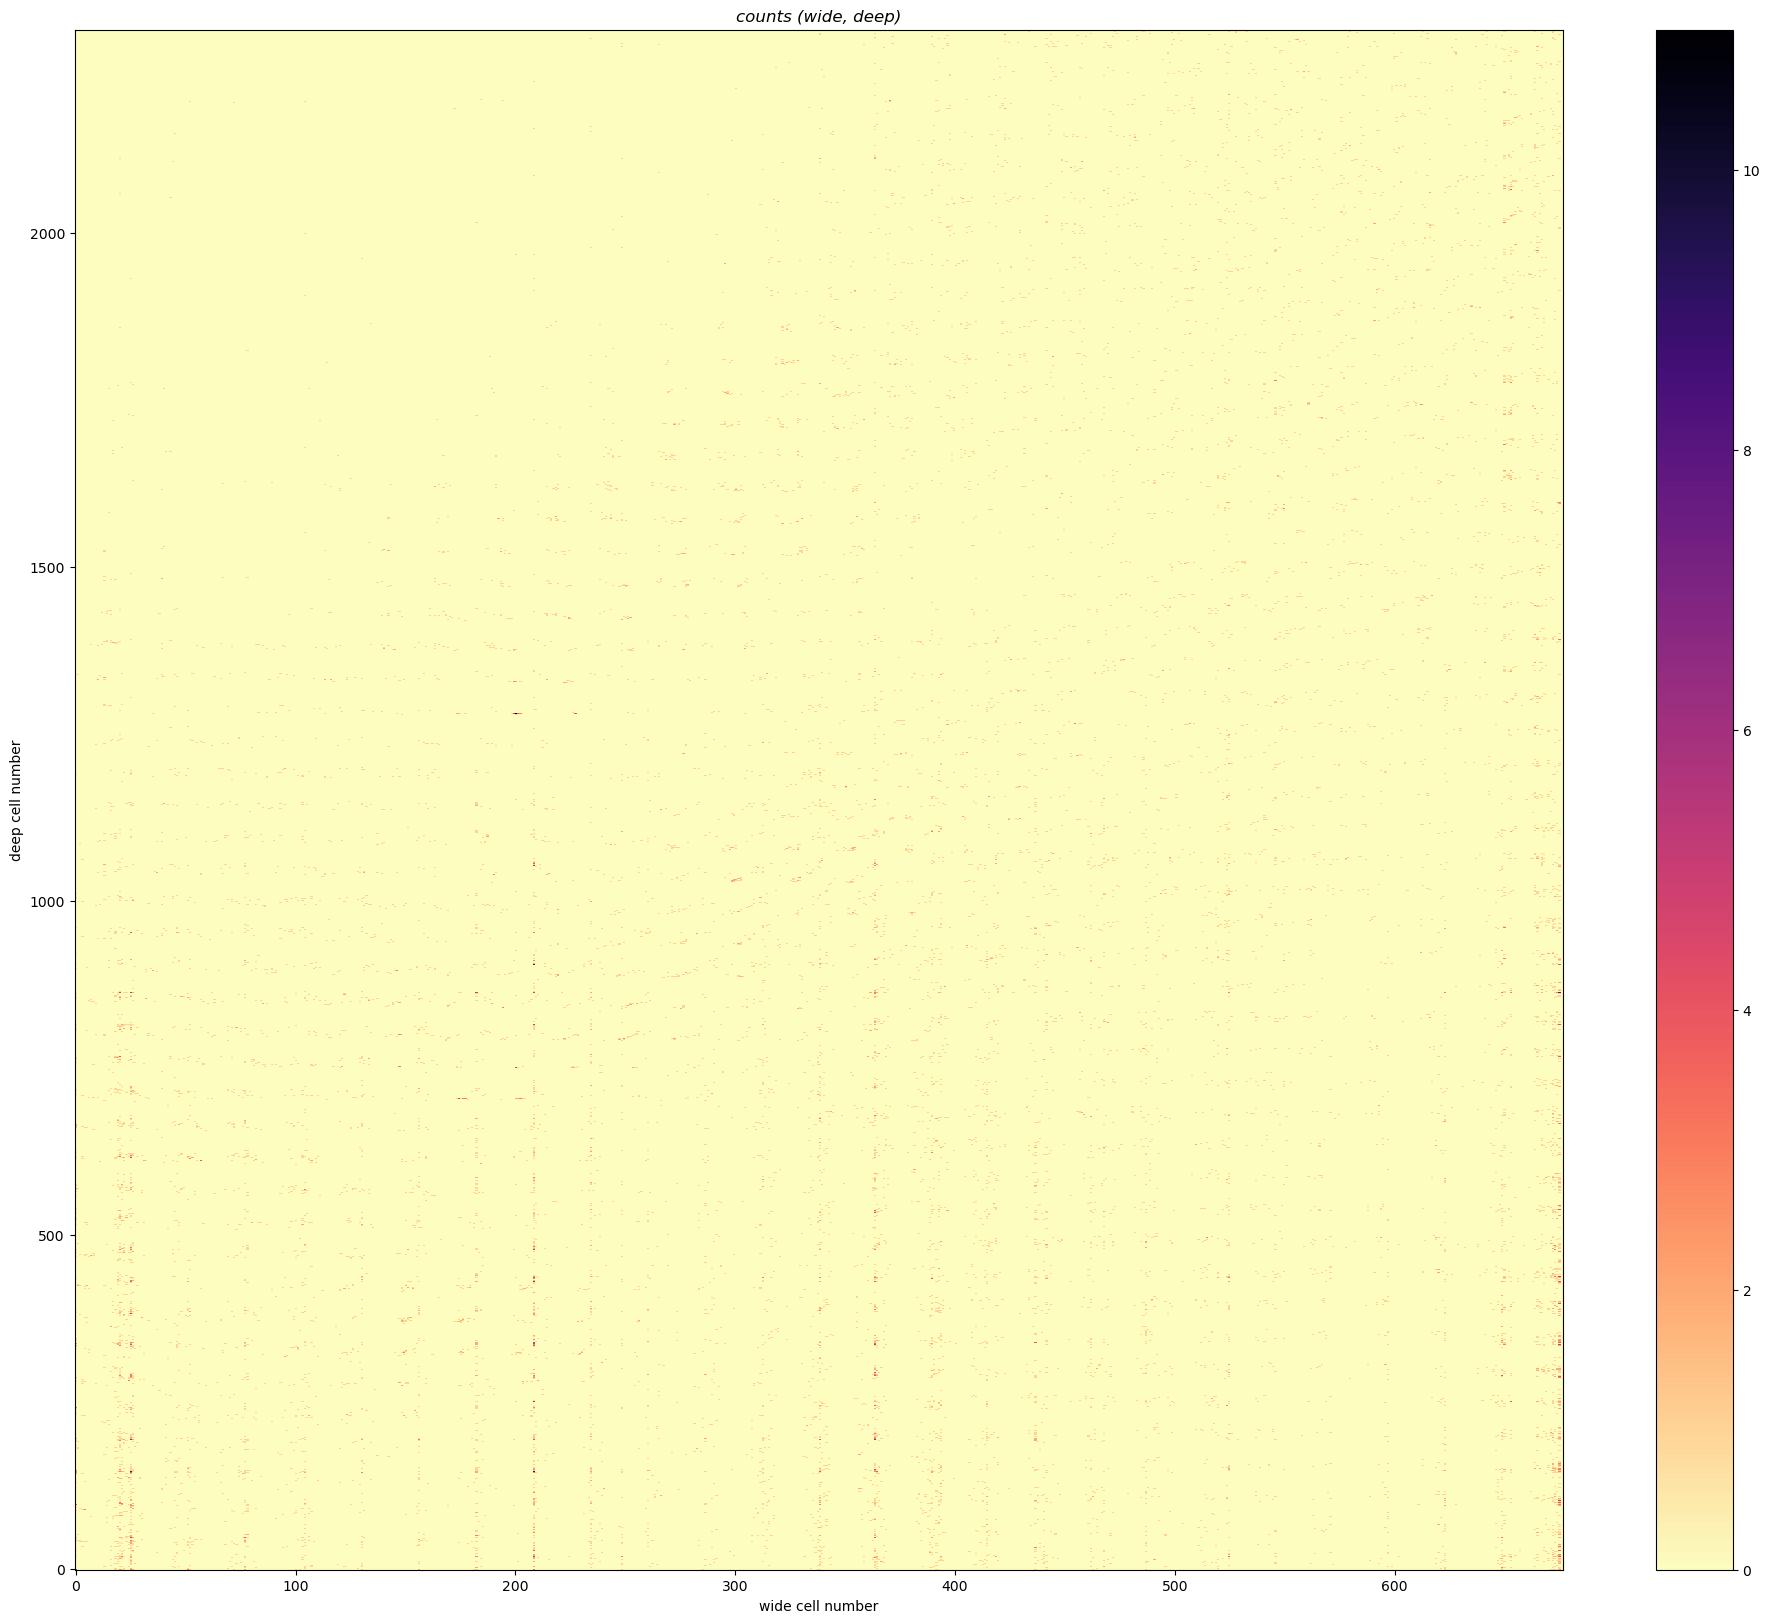

In [77]:
cmap='magma_r'
title = 'counts (wide, deep)'
plt.figure(figsize=(24,20))
plt.title(f'{title}',style='italic')
plt.xlabel('wide cell number')
plt.ylabel('deep cell number')
hist_ = plt.hist2d(WD_grid[:,0], WD_grid[:,1] ,bins=[np.linspace(-0.5, n_wide**2 + 0.5, n_wide**2+1), np.linspace(-0.5, n_deep**2 + 0.5, n_deep**2+1)],\
           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, label='counts')
plt.colorbar()
plt.show()

In [80]:
np.allclose(hist_[0], hist[0])

False

In [81]:
counts_deep = square_len_deep.i.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

In [124]:
balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_29072023.npy', balrog_term)

In [82]:
counts_wide = square_p_c_hat.p_pass.len
p_c_hat = ((counts_wide/counts_wide.sum()).values*square_det.detected_float['mean'].values).reshape(n_wide,n_wide)

In [83]:
p_c_p_c_hat = (p_c.flatten() * np.repeat(p_c_hat, n_deep**2).reshape(n_deep**2, n_wide**2).T) #p_c horizontal and p_c_hat vertical

In [84]:
p_c_c_hat = hist_[0]/hist_[0].sum()

In [85]:
p_c_c_hat.shape

(676, 2304)

In [71]:
p_c_c_hat.max()

0.0005222427954232541

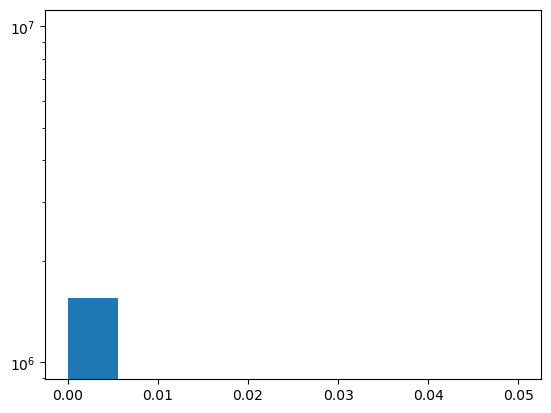

In [86]:
plt.hist(p_c_c_hat.flatten(), bins=np.linspace(0, .05, 10))
plt.yscale('log')

In [87]:
p_c_p_c_hat.shape

(676, 2304)

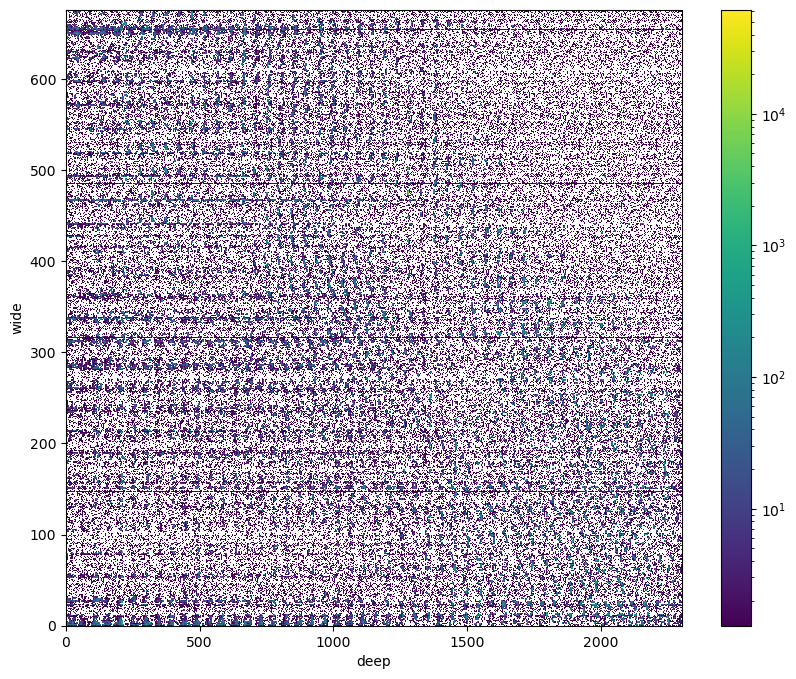

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(p_c_c_hat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1), norm=mpl.colors.LogNorm(), extent=[0,n_deep**2,0,n_wide**2], aspect=(n_deep/n_wide)**2)#mpl.colors.LogNorm())
plt.xlabel('deep')
plt.ylabel('wide')
plt.colorbar()
plt.show()

In [ ]:
i_deep = np.random.randint(0,n_deep**2)
plt.xlabel('Wide SOM cell number')
plt.xlim(0,n_wide**2)
plt.ylabel('Balrog Term')
plt.title(f'Deep SOM cell: {i_deep}')
plt.plot((p_c_c_hat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1))[:,i_deep])
plt.show()

plt.xlabel('Wide SOM cell number')
plt.xlim(0,n_wide**2)
plt.ylabel('Balrog Term')
plt.title(f'Deep SOM cell: {i_deep-1}')
plt.plot((p_c_c_hat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1))[:,i_deep-1])
plt.show()

plt.xlabel('Wide SOM cell number')
plt.xlim(0,n_wide**2)
plt.ylabel('Balrog Term')
plt.title(f'Deep SOM cell: {i_deep+1}')
plt.plot((p_c_c_hat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1))[:,i_deep+1])
plt.show()

In [89]:
positions_wide = np.array(np.unravel_index(np.arange(0,n_wide**2), (n_wide,n_wide)))

In [90]:
position_500 = np.array(np.unravel_index(500, (n_wide,n_wide)))

In [91]:
distance = np.sum(np.abs(positions_wide-position_500[:, None]),axis=0)

In [92]:
np.arange(0,n_wide**2)[distance<=2]

array([448, 473, 474, 475, 498, 499, 500, 501, 502, 525, 526, 527, 552])

In [93]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

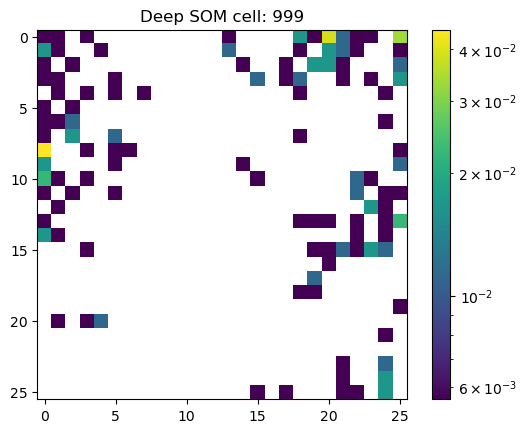

In [94]:
i_deep = 1000 #np.random.randint(0,n_deep**2)

idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

plt.title(f'Deep SOM cell: {i_deep-1}')

im = np.sum(p_c_c_hat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

im /= np.sum(im)

plt.title(f'Deep SOM cell: {i_deep-1}')
plt.imshow(im, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()

In [95]:
((21063/n_deep**2)*31)/n_wide

10.899989983974361

In [97]:
wide_deep.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'Ai', 'Ar', 'Az', 'FLUX_i', 'FLUX_i_ERR',
       'FLUX_r', 'FLUX_r_ERR', 'FLUX_z', 'FLUX_z_ERR', 'Truth_ind',
       'coadd_object_id', 'd_arcsec', 'dec', 'detected', 'ra', 'true_FLUX_i',
       'true_FLUX_r', 'true_FLUX_z', 'true_dec', 'true_ra', 'cells_x', 'ID',
       'Unnamed: 0_y', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I', 'cells_y',
       'u-g', 'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'i', 'u-i', 'g-i',
       'z-i', 'j-i', 'h-i', 'ks

In [98]:
wide_deep_det = wide_deep[wide_deep.detected&np.isfinite(wide_deep.BDF_MAG_DERED_CALIB_I)]

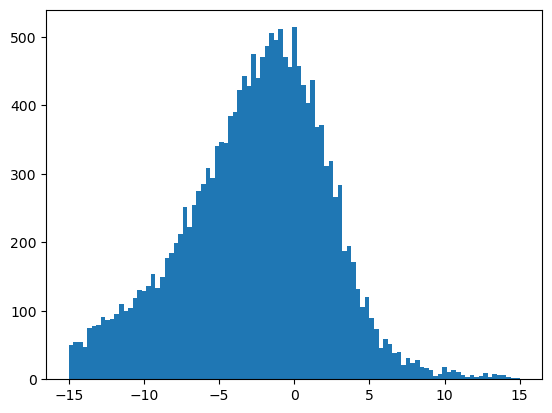

In [99]:
band='i'
plt.hist((wide_deep_det[f'FLUX_{band}']-wide_deep_det[f'BDF_FLUX_DERED_CALIB_{band.upper()}'])\
         /wide_deep_det[f'FLUX_{band}_ERR'], bins=np.linspace(-15,15,100))
plt.show()

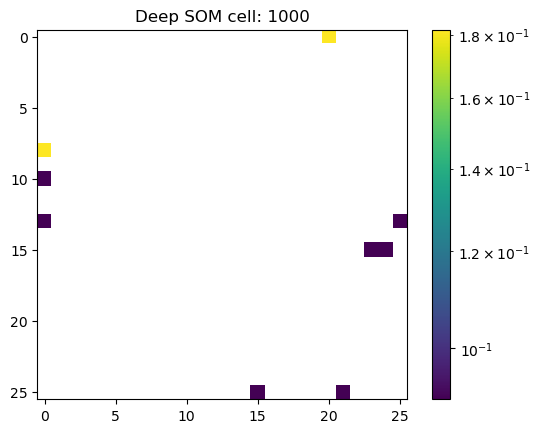

In [100]:
im = p_c_c_hat[:,i_deep].reshape(n_wide,n_wide)

im /= np.sum(im)

plt.title(f'Deep SOM cell: {i_deep}')
plt.imshow(im, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()

In [101]:
plt.hist((p_c_c_hat-p_cchat).flatten(), bins=np.linspace(0,1e-3,100));
plt.ylabel('counts')
plt.xlabel('difference between Raul\'s and Alex\'s ways of calculating joint probability')
plt.yscale('log')

NameError: name 'p_cchat' is not defined

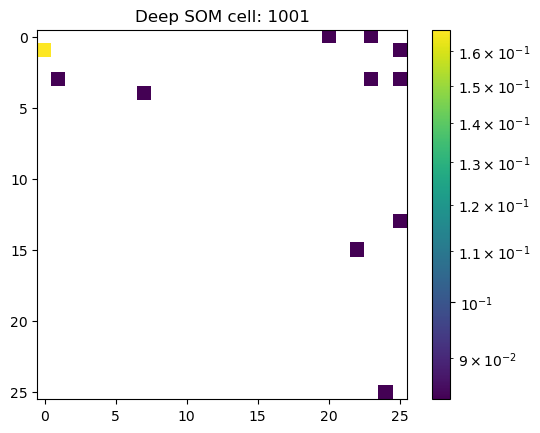

In [102]:
im = p_c_c_hat[:,i_deep+1].reshape(n_wide,n_wide)

im /= np.sum(im)

plt.title(f'Deep SOM cell: {i_deep+1}')
plt.imshow(im, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()

In [105]:
unique_ids, index, rev_index, counts_true = np.unique(wide_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

#unique_ids_detected, counts_detected = np.unique(wide_deep.ID.values[wide_deep.passes.values&wide_deep.detected.values], return_counts=True)

In [106]:
(unique_ids==wide_deep.ID.values[index]).all()

True

In [107]:
InjDF = pd.DataFrame({'ID': wide_deep.ID.values[index],
'wide_cell': wide_deep.wide_cells.values[index],
'deep_cell': wide_deep.deep_cells.values[index],
'N_inj':counts_true})

In [108]:
N_wide, N_deep = 26**2, 48**2
sel_mask = wide_deep.detected&wide_deep.passes&(~(np.isnan(wide_deep.deep_cells.values) | np.isnan(wide_deep.wide_cells.values)))
p_cchat = np.zeros((N_wide, N_deep))
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int), InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 / InjDF.N_inj.values[sel_mask[index]])

In [109]:
p_cchat/=p_cchat.sum()

In [110]:
np.allclose(p_cchat, p_c_c_hat)

False

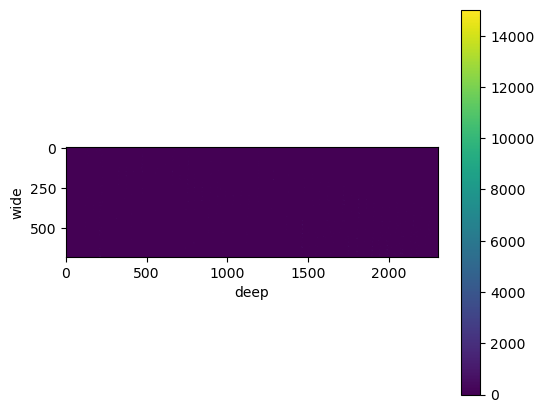

In [56]:
plt.figure(figsize=(6,5))
plt.imshow(p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1), norm=norm)#mpl.colors.LogNorm())
plt.xlabel('deep')
plt.ylabel('wide')
plt.colorbar()

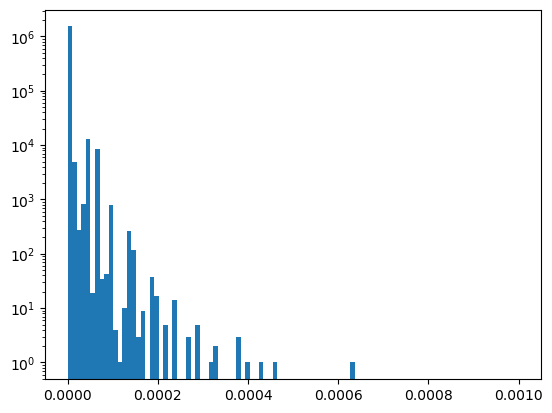

In [123]:
plt.hist(np.abs(p_cchat-p_c_c_hat).flatten(), bins=np.linspace(0,0.001, 100))
plt.yscale('log')
plt.show()

In [57]:
np.save('/project/chihway/raulteixeira/data/BalrogTerm_v01_29072023_26x48.npy', np.array(p_cchat/p_c_p_c_hat))

In [58]:
pd.read_csv(f'/project/chihway/raulteixeira/data/metacal_gold_fluxes+ids_00.csv.gz')

,Unnamed: 0,COADD_OBJECT_ID,FLUX_R,FLUX_ERR_R,FLUX_I,FLUX_ERR_I,FLUX_Z,FLUX_ERR_Z
0,0,7109304883,3697.074912,41.510975,4342.987764,49.896796,5399.346127,101.126423
1,1,7109304892,1060.265660,32.105632,2483.591726,41.284574,3354.406431,87.896135
2,2,7109304896,2632.422146,45.376178,3391.575227,68.988487,4295.313674,125.899520
3,3,7109304898,2133.722123,38.464039,2287.077329,46.422072,3271.006405,99.938773
4,4,7109304902,751.718904,53.678323,992.224432,54.098644,1250.526081,120.534894
...,...,...,...,...,...,...,...,...
1007426,1007426,7060275324,693.108920,47.816237,960.850179,38.084887,1235.514641,80.938704
1007427,1007427,7060275338,658.982647,49.615799,1051.530890,50.868904,743.134941,90.229331
1007428,1007428,7060275356,628.072729,26.592287,1321.870056,42.254617,1561.599320,77.811697
1007429,1007429,7060275403,1097.417628,40.710246,2471.639842,46.908366,3687.566987,97.080360


In [59]:
#1. conditional probability p(c_hat|c) for multiple c's

#2. choose c's that are very close to each other and check if they give similar p(c_hat|c) in c_hat space 
    # "p(chat | c) and p(chat | c’) should be similar when c and c’ are similar"
    
#3. three panel plot: p(c), p(c|gold), p(c|gold)/p(c) (gold passing probability of a cell. Fainter 
# galaxies should have lower det. rates), average i-band magnitude before masking by detection

# goals: check if balrog is going ok and if I didn't make any mistakes calculating probabilities

# make file with tomobins 26x26

## calculate tomographic bins

In [ ]:
/project/chihway/raulteixeira/data/som_metacal_gold_wide_26x

In [53]:
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v01_29072023.npy', np.array(p_c_c_hat/p_c_p_c_hat))

NameError: name 'p_c_p_c_hat' is not defined

In [40]:
# group = wide_deep[['wide_cells', 'deep_cells', 'ID']].groupby('ID')

# df_list = []
# for g_label, g in group:
#     df_list.append(g)

# threedfs = pd.concat(df_list)

# threedfs[wide_deep.detected&goldish_cut(wide_deep)]

In [44]:
unique_ids, counts_true

(array([691667162, 691667226, 691667231, ..., 713202731, 713202755,
        713202768]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [45]:
wide_deep.wide_cells

0         0
1         0
2         0
3         0
4         0
         ..
129595    0
129596    0
129597    0
129598    0
129599    0
Name: wide_cells, Length: 129600, dtype: int64

In [46]:
# list of wide som cell id wide_som_cell_id, deep_som_cell_id, N_inj (three lists of same length n_objects)
# wide SOM might be too big, use 26 (less dynamic range and just three colors in wide, in comparison to Deep Fields)

In [50]:
np.save('/project/chihway/raulteixeira/data/Correct_BalrogTerm_v01_29072023.npy', p_cchat)

In [51]:
# count each pair of (c, c_hat) divided by number of injections
    # easier way: just add 1/N_inj(obj_id) for each cell

In [52]:
wide.ID

0         698316262
1         712167777
2         697443896
3         698284925
4         697537883
            ...    
129595    691927777
129596    697403822
129597    697292159
129598    692006773
129599    698345533
Name: ID, Length: 129600, dtype: int64

In [54]:
np.array([1, 2, 3]) * np.repeat([4, 5, 6], 3).reshape(3,3)

array([[ 4,  8, 12],
       [ 5, 10, 15],
       [ 6, 12, 18]])

In [78]:
p_c_hat

array([[1.25000000e-03, 1.23456790e-04, 1.54320988e-04, 2.23765432e-04,
        1.69753086e-04, 1.69753086e-04, 7.71604938e-05, 7.71604938e-05,
        5.40123457e-05, 7.71604938e-05, 9.25925926e-05, 5.40123457e-05,
        3.85802469e-05, 3.24074074e-04, 1.77469136e-04, 2.16049383e-04,
        3.16358025e-04, 2.93209877e-04, 5.78703704e-04, 1.29629630e-03,
        2.39197531e-03, 1.16512346e-03, 5.86419753e-04, 4.93827160e-04,
        5.55555556e-04, 3.27932099e-03],
       [1.23456790e-03, 1.15740741e-04, 1.31172840e-04, 1.23456790e-04,
        1.08024691e-04, 1.15740741e-04, 1.00308642e-04, 7.71604938e-05,
        2.31481481e-05, 6.94444444e-05, 6.17283951e-05, 1.08024691e-04,
        4.62962963e-05, 2.54629630e-04, 9.25925926e-05, 1.15740741e-04,
        3.85802469e-05, 1.92901235e-04, 2.62345679e-04, 4.08950617e-04,
        4.62962963e-04, 2.77777778e-04, 1.77469136e-04, 9.25925926e-05,
        1.08024691e-04, 6.25000000e-04],
       [7.02160494e-04, 1.54320988e-04, 2.08333333e-04

In [75]:
np.repeat(p_c_hat, n_deep**2).reshape(n_deep**2, n_wide**2).T

array([[0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383],
       [0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383],
       [0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383],
       ...,
       [0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383],
       [0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383],
       [0.00125   , 0.00125   , 0.00125   , ..., 0.00424383, 0.00424383,
        0.00424383]])

In [72]:
p_c_p_c_hat

array([[6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06],
       [6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06],
       [6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06],
       ...,
       [6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06],
       [6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06],
       [6.98599769e-06, 1.55858817e-06, 1.52172275e-06, ...,
        4.79781485e-07, 5.97988517e-07, 1.07081665e-06]])

In [66]:
p_c.size

2304

In [65]:
2304*676/456976

3.408284023668639

In [ ]:
p_c_p_c_hat

In [ ]:
hist[0].size

In [36]:
WD_grid.shape

(90338, 2)

In [ ]:
wide_deep_counts = hist[0]

In [ ]:
p_c_chat = wide_deep_counts/wide_deep_counts.sum()

In [34]:
np.meshgrid(p_c.flatten(), p_c_hat.flatten())

[array([[0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232],
        [0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232],
        [0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232],
        ...,
        [0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232],
        [0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232],
        [0.0055888 , 0.00124687, 0.00121738, ..., 0.00011305, 0.00014091,
         0.00025232]]),
 array([[0.00107227, 0.00107227, 0.00107227, ..., 0.00107227, 0.00107227,
         0.00107227],
        [0.00021445, 0.00021445, 0.00021445, ..., 0.00021445, 0.00021445,
         0.00021445],
        [0.00025735, 0.00025735, 0.00025735, ..., 0.00025735, 0.00025735,
         0.00025735],
        ...,
        [0.00034313, 0.00034313, 0.00034313, ..., 0.00034313, 0.00034313,
         0.00034313],
        [0.0

In [29]:
p_c_p_c_hat.shape

(2304,)

In [ ]:
Balrog_Term = p_c_chat/(p_c_hat*p_c)

In [ ]:
title = 'Balrog Term'
image = plt.imshow(Balrog_Term, cmap=cmap, vmin=vmin, vmax=vmax, norm=mpl.colors.LogNorm())
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()